In [1]:
import pymongo
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
import seaborn as sns

In [2]:
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

In [3]:
db = client.testdb
tripadvisor = db.tripadvisor
yelp = db.yelp

In [4]:
# grab from mongo, sort by date, rename index to 'order' of appearance
df = pd.DataFrame(list(yelp.find()))
df = df.drop('_id', 1)
df = df.sort_values('date').reset_index()
df.columns = ['order' if x=='index' else x for x in df.columns]
df['day_of_week'] = df['date'].dt.weekday_name
df.head(10)

,order,city,date,id,rating,state,text,username,day_of_week
0,1551,Fairfax,2006-12-05,F41LRfdyzj4yagcDVsIS7g,4,VA,"I guess the ""Tavern"" in the name refers to the...",Gayle G.,Tuesday
1,1785,Washington,2006-12-18,QNJmkKw9hxN74IDCNLMEkg,5,DC,If you think this restaurant serving an Asian ...,Lydia P.,Monday
2,2041,Toronto,2007-01-09,FqptloYidzdvoratrazZ0w,3,Canada,An interesting experience but nothing spectacu...,Hratch P.,Tuesday
3,1786,Arlington,2007-04-23,aSvpHZYUXAdCMKbnF4iyKg,5,VA,The only restaurant in DC I give a 5-star. I h...,Haesung H.,Monday
4,1816,Alexandria,2007-05-21,UxpWvr2L7mzn8hY0iQDAoA,5,VA,I loved this restaurant. The interior is beau...,Beth F.,Monday
5,1976,Washington,2007-05-25,Qoq4XIHKdUVjDi1av8jnaA,5,DC,I had the most wonderful dinner here with my g...,RonAnderson ..,Friday
6,1803,Rockville,2007-06-01,pXNfAxsQHgf5TaY-F6wflA,4,MD,I had lunch at Blue Duck Tavern today and was ...,Betsy T.,Friday
7,1815,Sterling,2007-06-12,n-xTB-LQ8U6aN8Ix0Ei8Iw,5,VA,"Food -- One of their ""claims to fame"" is that ...",Sandra K.,Tuesday
8,1805,San Francisco,2007-06-26,YYYalIsJ_NkGCd2hbJ6YgQ,4,CA,We have been visiting DC and were looking for ...,Carla B.,Tuesday
9,1846,San Francisco,2007-07-01,45NswQQmgdZIFYvZ_pql8A,5,CA,I went here with a group - there were 6 of us ...,Bahareh W.,Sunday


In [5]:
days_grouped = df.groupby(['rating', 'day_of_week']).count()
days_grouped = days_grouped.reset_index()
days_grouped

,rating,day_of_week,order,city,date,id,state,text,username
0,1,Friday,4,4,4,4,4,4,4
1,1,Monday,15,15,15,15,15,15,15
2,1,Saturday,8,8,8,8,8,8,8
3,1,Sunday,13,13,13,13,13,13,13
4,1,Thursday,6,6,6,6,6,6,6
5,1,Tuesday,9,9,9,9,9,9,9
6,1,Wednesday,7,7,7,7,7,7,7
7,2,Friday,12,12,12,12,12,12,12
8,2,Monday,20,20,20,20,20,20,20
9,2,Saturday,20,20,20,20,20,20,20


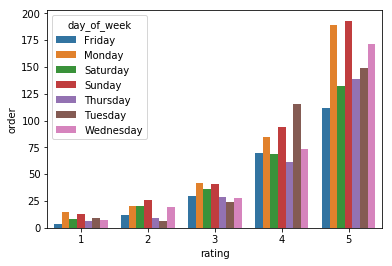

In [6]:
sns.barplot(data = days_grouped, x='rating', y='order', hue='day_of_week')

In [7]:
# group by date with monthly average
df1 = df.groupby(pd.Grouper(key='date', freq='1M')).mean()
df1 = df1[['rating']]
df1.head()

,rating
date,
2006-12-31,4.5
2007-01-31,3.0
2007-02-28,NaN
2007-03-31,NaN
2007-04-30,5.0


In [8]:
# add missing values
df1 = (df1
       .resample('M')
       .mean()
       .interpolate('linear'))
df1.head()

,rating
date,
2006-12-31,4.500000
2007-01-31,3.000000
2007-02-28,3.666667
2007-03-31,4.333333
2007-04-30,5.000000


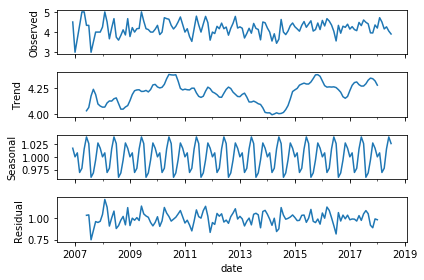

In [9]:
# decompose data
series = df1
# series = df[['date','rating']].set_index('date')
result = seasonal_decompose(series, model='multiplicative', freq=12)
result.plot()
pyplot.show()

In [10]:
df1 = df1.reset_index()
df1.head()

,date,rating
0,2006-12-31,4.500000
1,2007-01-31,3.000000
2,2007-02-28,3.666667
3,2007-03-31,4.333333
4,2007-04-30,5.000000


In [11]:
# decompose from 2011
series = df1.loc[df1['date'] > '2011-01-01'].set_index('date')
# series = df[['date','rating']].set_index('date')
result = seasonal_decompose(series, model='multiplicative', freq=12)
# result.plot()
# pyplot.show()


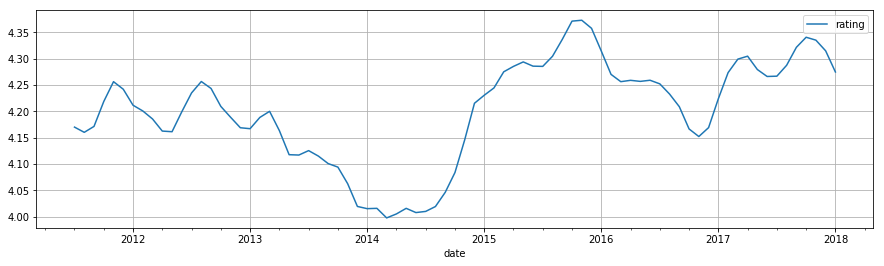

In [12]:
result.trend.plot(figsize=(15,4), grid=True)

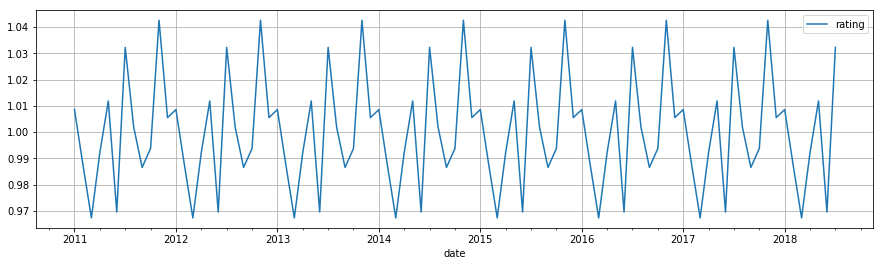

In [13]:
result.seasonal.plot(figsize=(15,4), grid=True)

In [14]:
result.seasonal.loc[result.seasonal['rating'].idxmax()]

rating    1.042574
Name: 2011-11-30 00:00:00, dtype: float64

In [15]:
result.seasonal.loc[result.seasonal['rating'].idxmin()]

rating    0.967369
Name: 2011-03-31 00:00:00, dtype: float64

In [16]:
# result.seasonal = result.seasonal.reset_index()
result.seasonal.head()

,rating
date,
2011-01-31,1.008585
2011-02-28,0.987550
2011-03-31,0.967369
2011-04-30,0.992291
2011-05-31,1.011876


In [17]:
result.seasonal.loc[result.seasonal['rating'] > (result.seasonal.max().rating - 0.02)]

,rating
date,
2011-07-31,1.032261
2011-11-30,1.042574
2012-07-31,1.032261
2012-11-30,1.042574
2013-07-31,1.032261
2013-11-30,1.042574
2014-07-31,1.032261
2014-11-30,1.042574
2015-07-31,1.032261


In [18]:
result.seasonal.loc[result.seasonal['rating'] < (result.seasonal.min().rating + 0.02) ]

,rating
date,
2011-03-31,0.967369
2011-06-30,0.969600
2011-09-30,0.986571
2012-03-31,0.967369
2012-06-30,0.969600
2012-09-30,0.986571
2013-03-31,0.967369
2013-06-30,0.969600
2013-09-30,0.986571


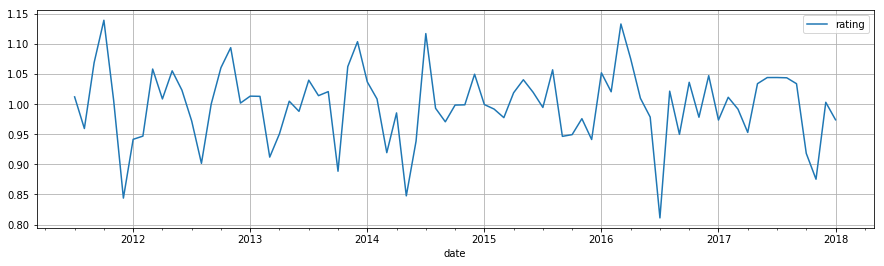

In [19]:
result.resid.plot(figsize=(15,4), grid=True)

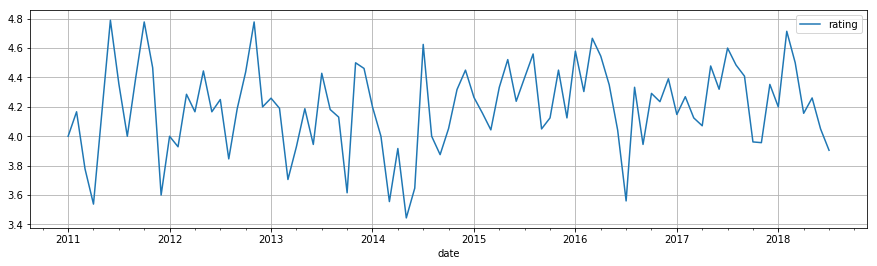

In [20]:
result.observed.plot(figsize=(15,4), grid=True)

In [21]:
df_2017 = df[df['date'].dt.year == 2017]

In [192]:
df_2017.

order           304
date            304
id              304
rating          304
text            304
userlocation    304
username        304
dtype: int64

In [22]:
df2 = df_2017.groupby(pd.Grouper(key='date', freq='1M')).mean()
df2 = df2[['rating']]

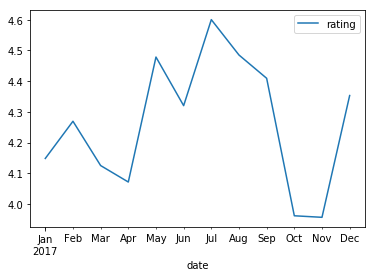

In [23]:
df2.plot()

In [24]:
import nltk
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [25]:
comment_words = ' '
stopwords = set(STOPWORDS)
stopwords.add('blue')
stopwords.add('duck')
stopwords.add('tavern')
stopwords.add('restaurant')
stopwords.add('food')

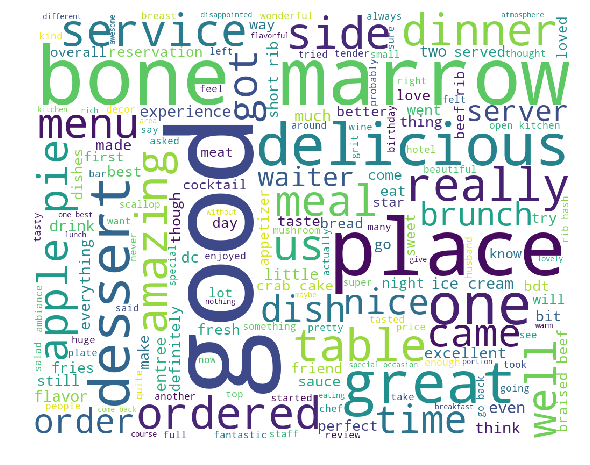

In [26]:
for ind, row in df.iterrows():
    tokens = row.text.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
         
    for words in tokens:
        comment_words += (words + ' ')
        
wordcloud = WordCloud(width = 1000, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 13).generate(comment_words)

plt.figure(figsize = (8, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()
    